<a href="https://colab.research.google.com/github/RahaviSelvarajan/yolov5_colab/blob/main/SBI_YOLO_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jul 18 17:47:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python --version

Python 3.7.13


##***Mount Google Drive***

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##***Mount Onedrive to get the dataset***

In [ ]:
!wget https://downloads.rclone.org/v1.57.0/rclone-v1.57.0-linux-amd64.deb
!apt install ./rclone-v1.57.0-linux-amd64.deb

In [ ]:
!rclone config

In [ ]:
!sudo mkdir /content/onedrive
!nohup rclone --vfs-cache-mode writes mount onedrive: /content/onedrive &

**Run the below cell only when onedrive gets disconnected in the middle of training and mount it again using the above command.**

In [ ]:
!fusermount -u /content/onedrive

##***Git Clone YOLOv5-Pytorch model***

In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12758, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 12758 (delta 19), reused 31 (delta 18), pack-reused 12719
Receiving objects: 100% (12758/12758), 12.38 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (8774/8774), done.


Install the required python packages

In [5]:
%cd yolov5
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Copy the data configuration to the data folder

In [6]:
# Copy data configuration file into yolo directory
!cp /content/drive/MyDrive/Yolov5/sleepaid.yaml /content/yolov5/data/

##**Training**

In [ ]:
# Import libraries
import os
import glob
import shutil
from pathlib import Path

In [ ]:
# Get the train and test dataset from different folds
def train_test_split(root_dir, test_fold):

    # Make directory for training and testing images
    train_imgs = Path('/content/yolov5/data/images/train')
    test_imgs = Path('/content/yolov5/data/images/test')

    if train_imgs.exists():
      shutil.rmtree(train_imgs)
    if test_imgs.exists():
      shutil.rmtree(test_imgs)

    os.mkdir(train_imgs)
    os.mkdir(test_imgs)

    # Make directory for target labels
    train_labels = Path('/content/yolov5/data/labels/train')
    test_labels = Path('/content/yolov5/data/labels/test')

    if train_labels.exists():
      shutil.rmtree(train_labels)
    if test_labels.exists():
      shutil.rmtree(test_labels)

    os.makedirs(train_labels)
    os.makedirs(test_labels)

    for j, image in enumerate(glob.iglob(os.path.join('/content/drive/MyDrive/Negatives', "*.jpg"))):
      if j<150:
        shutil.copy(image, train_imgs)
      else:
        shutil.copy(image, test_imgs)

    for i, folder in enumerate(os.listdir(root_dir)):
      folder_path = os.path.join(root_dir, folder)
      file_list = [image for image in glob.glob(os.path.join(folder_path, '*.jpg'))]

      # Get the train folds
      if i != test_fold:
        for image in file_list:
          shutil.copy(image, train_imgs)
          shutil.copy(os.path.splitext(image)[0] + '.txt', train_labels)

      # Get the test fold
      elif i == test_fold:
        for image in file_list:
          shutil.copy(image, test_imgs)
          shutil.copy(os.path.splitext(image)[0] + '.txt', test_labels)

for i in range(1):
  train_test_split('/content/drive/MyDrive/Dataset', i)
  !python train.py --batch-size 8 --img-size 1920 --data 'sleepaid.yaml' --weights 'yolov5s.pt' --epochs 300 --cfg 'yolov5s.yaml'  \
                   --save-period 50 --patience 20 --hyp '/content/drive/MyDrive/Yolov5/hyp.yaml' --project '/content/drive/MyDrive/Yolov5/runs/final_train' 
  !mv /content/drive/MyDrive/Yolov5/runs/final_train/exp /content/drive/MyDrive/Yolov5/runs/final_train/results"$i"

##**Validation**

In [ ]:
!unzip /content/drive/MyDrive/val.zip

In [ ]:
# unzip the DWU128 participant
!unzip /content/drive/MyDrive/DWU128.zip -d /content/DWU128

In [ ]:
val_imgs = Path('/content/yolov5/data/images/test')
val_labels = Path('/content/yolov5/data/labels/test')

if val_imgs.exists():
  shutil.rmtree(val_imgs)
if val_labels.exists():
  shutil.rmtree(val_labels)

os.mkdir(val_imgs)
os.makedirs(val_labels)  

# for folder in os.listdir('/content/DWU128'):
#   folder_path = os.path.join('/content/DWU128', folder)
#   if not folder.startswith('.'):
for file in os.listdir('/content/DWU128'):
  extension = os.path.splitext(file)[1]
  f_path = os.path.join('/content/DWU128', file)
  if extension == '.txt':
    shutil.copy(f_path, val_labels)
  elif extension == '.jpg':
    shutil.copy(f_path, val_imgs)

In [ ]:
!python val.py --batch-size 8 --img-size 1920 --data 'sleepaid.yaml' --weights '/content/drive/MyDrive/Yolov5/runs/final_train/results2/weights/best.pt' --project '/content/drive/MyDrive/Yolov5/runs/final_train' 

##**Testing**

In [8]:
!python detect.py --source '/content/drive/MyDrive/B-DWU128.mp4' --max-det 1 --conf-thres 0.1 --iou-thres 0.2 --img-size 1920 --weights '/content/drive/MyDrive/Yolov5/runs/final_train/results2/weights/best.pt' --save-txt --data '/content/yolov5/data/sleepaid.yaml'

detect: weights=['/content/drive/MyDrive/Yolov5/runs/final_train/results2/weights/best.pt'], source=/content/drive/MyDrive/B-DWU128.mp4, data=/content/yolov5/data/sleepaid.yaml, imgsz=[1920, 1920], conf_thres=0.1, iou_thres=0.2, max_det=1, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7074853 parameters, 0 gradients, 16.0 GFLOPs
video 1/1 (1/1572) /content/drive/MyDrive/B-DWU128.mp4: 1088x1920 1 B-Left_recovery, Done. (0.045s)
video 1/1 (2/1572) /content/drive/MyDrive/B-DWU128.mp4: 1088x1920 1 B-Left_recovery, Done. (0.045s)
video 1/1 (3/1572) /content/drive/MyDrive/B-DWU128.mp4: 1088x1920 1 B-Left_recovery, Don

##**Position Time Quantification**

In [61]:
import cv2
import torch
from datetime import datetime
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [ ]:
def load_model():

    model = torch.hub.load('ultralytics/yolov5',
                            'custom', path='/content/drive/MyDrive/Yolov5/runs/final_train/results2/weights/best.pt')
    
    model.max_det = 1
    model.conf_thres = 0.1
    model.iou_thres = 0.2
    
    classes = ['B-Left_recovery', 'B-Left_lateral', 'B-Left_tilt', 'B-Supine', 'B-Supine_thorax_with_Left_pelvic_tilt', 
                'B-Supine_thorax_with_Right_pelvic_tilt', 'B-Supine_pelvis_with_Left_thorax_tilt', 
                'B-Supine_pelvis_with_Right_thorax_tilt', 'B-Right_tilt', 'B-Right_lateral', 'B-Right_recovery', 'B-Sitting', 
                'N_B-Left_recovery', 'N_B-Left_lateral', 'N_B-Left_tilt', 'N_B-Supine', 'N_B-Supine_thorax_with_Left_pelvic_tilt', 
                'N_B-Supine_thorax_with_Right_pelvic_tilt', 'N_B-Supine_pelvis_with_Left_thorax_tilt', 
                'N_B-Supine_pelvis_with_Right_thorax_tilt', 'N_B-Right_tilt', 'N_B-Right_lateral', 'N_B-Right_recovery', 'N_B-Sitting']
                    
    return model, classes

    
def detect_objects(video_file, model, classes):

  count = 0 

  cap = cv2.VideoCapture(video_file)
  fps = cap.get(cv2.CAP_PROP_FPS)
  objects = list()
  pt_data = dict()
  while True:
      ret, frame = cap.read()
      if ret:
        result = model(frame)
        labels = result.xyxyn[0][:, -1].cpu().numpy()
        if len(labels) != 0:
          count += 1
          objects.append(classes[int(labels[0])])
        # if len(objects) > 2:
        #   if objects[-1] != objects[-2]:      
        #     if objects[-2] not in pt_data:
        #       pt_data[objects[-2]] = 0
        #     pt_data[objects[-2]] += count/fps     
        #     count = 0
      else:
          return objects

In [ ]:
model, classes = load_model()

data = detect_objects('/content/drive/MyDrive/B-DWU128.mp4', model, classes)

print(data)

#### Code based on python bash script

### For video with bedsheet

In [43]:
# Code based on the bash script for python
cap = cv2.VideoCapture('/content/drive/MyDrive/B-DWU128.mp4')
fps = cap.get(cv2.CAP_PROP_FPS) 

classes = ['B-Left_recovery', 'B-Left_lateral', 'B-Left_tilt', 'B-Supine', 'B-Supine_thorax_with_Left_pelvic_tilt', 
          'B-Supine_thorax_with_Right_pelvic_tilt', 'B-Supine_pelvis_with_Left_thorax_tilt', 
          'B-Supine_pelvis_with_Right_thorax_tilt', 'B-Right_tilt', 'B-Right_lateral', 'B-Right_recovery', 'B-Sitting', 
          'N_B-Left_recovery', 'N_B-Left_lateral', 'N_B-Left_tilt', 'N_B-Supine', 'N_B-Supine_thorax_with_Left_pelvic_tilt', 
          'N_B-Supine_thorax_with_Right_pelvic_tilt', 'N_B-Supine_pelvis_with_Left_thorax_tilt', 
          'N_B-Supine_pelvis_with_Right_thorax_tilt', 'N_B-Right_tilt', 'N_B-Right_lateral', 'N_B-Right_recovery', 'N_B-Sitting']

labels_files = glob.glob('/content/drive/MyDrive/B-DWU128_pt/labels/*.txt')
labels_files.sort(key=os.path.getctime)
predictions = []

for file in labels_files:
  with open(file, 'r') as f:
    line = f.readlines()
    # print(line)
    index = int(line[0].split(" ")[0])
    predictions.append(classes[index])

In [52]:
# Get the time spent in each position
from collections import Counter
counts = Counter(predictions)
for item, count in counts.items():
    counts[item] /= 10.0
print(counts)

Counter({'B-Sitting': 19.9, 'B-Supine': 17.3, 'B-Right_tilt': 14.6, 'B-Right_lateral': 13.3, 'B-Supine_pelvis_with_Right_thorax_tilt': 12.9, 'B-Supine_thorax_with_Left_pelvic_tilt': 12.8, 'B-Left_tilt': 11.8, 'B-Left_lateral': 11.0, 'B-Supine_pelvis_with_Left_thorax_tilt': 10.9, 'B-Supine_thorax_with_Right_pelvic_tilt': 10.6, 'B-Right_recovery': 10.6, 'B-Left_recovery': 8.2, 'N_B-Sitting': 0.6, 'N_B-Supine': 0.5, 'N_B-Supine_thorax_with_Left_pelvic_tilt': 0.2, 'N_B-Left_tilt': 0.1})


#### Display of position and time spent 

In [66]:
df = pd.DataFrame.from_dict(counts, orient='index', columns=['Time spent'])
df.index.name = 'Position'
display(df)

,Time spent
Position,
B-Left_recovery,8.2
B-Supine_pelvis_with_Left_thorax_tilt,10.9
B-Left_lateral,11.0
B-Left_tilt,11.8
B-Supine,17.3
B-Supine_thorax_with_Right_pelvic_tilt,10.6
B-Supine_thorax_with_Left_pelvic_tilt,12.8
B-Supine_pelvis_with_Right_thorax_tilt,12.9
B-Right_tilt,14.6


#### Graph

<Figure size 720x576 with 0 Axes>

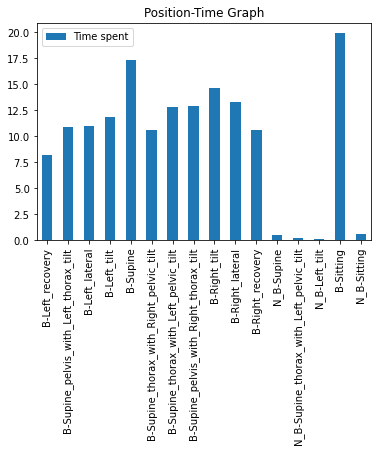

In [62]:
plt.figure(figsize=(10, 8))
df.plot(y = 'Time spent', kind='bar')
plt.title('Position-Time Graph')
plt.show()

#### Number of position changes

In [64]:
# Number of position changes
print('Number of position changes:', len(df.index))

Number of position changes: 16


### For video with no bedsheet

In [47]:
labels_files = glob.glob('/content/drive/MyDrive/N_B-DWU128_pt/labels/*.txt')
labels_files.sort(key=os.path.getctime)
nb_predictions = []

for file in labels_files:
  with open(file, 'r') as f:
    line = f.readlines()
    # print(line)
    index = int(line[0].split(" ")[0])
    nb_predictions.append(classes[index])

In [50]:
from collections import Counter
nb_counts = Counter(nb_predictions)
for item, count in nb_counts.items():
    nb_counts[item] /= 10.0
print(nb_counts)

Counter({'N_B-Supine': 23.2, 'N_B-Supine_pelvis_with_Left_thorax_tilt': 20.2, 'N_B-Supine_thorax_with_Right_pelvic_tilt': 19.9, 'N_B-Right_lateral': 18.3, 'N_B-Right_recovery': 17.5, 'N_B-Supine_thorax_with_Left_pelvic_tilt': 13.7, 'N_B-Left_recovery': 11.4, 'N_B-Right_tilt': 11.3, 'N_B-Supine_pelvis_with_Right_thorax_tilt': 10.8, 'N_B-Left_lateral': 10.5, 'N_B-Left_tilt': 9.5, 'B-Supine_thorax_with_Right_pelvic_tilt': 0.4, 'B-Right_tilt': 0.1})


#### Display of position and time spent

In [67]:
n_df = pd.DataFrame.from_dict(nb_counts, orient='index', columns=['Time spent'])
df.index.name = 'Position'
display(n_df)

,Time spent
N_B-Left_recovery,11.4
N_B-Left_lateral,10.5
N_B-Left_tilt,9.5
N_B-Supine_thorax_with_Left_pelvic_tilt,13.7
N_B-Supine,23.2
N_B-Supine_thorax_with_Right_pelvic_tilt,19.9
B-Supine_thorax_with_Right_pelvic_tilt,0.4
N_B-Supine_pelvis_with_Left_thorax_tilt,20.2
N_B-Supine_pelvis_with_Right_thorax_tilt,10.8
N_B-Right_tilt,11.3


#### Graph

<Figure size 720x576 with 0 Axes>

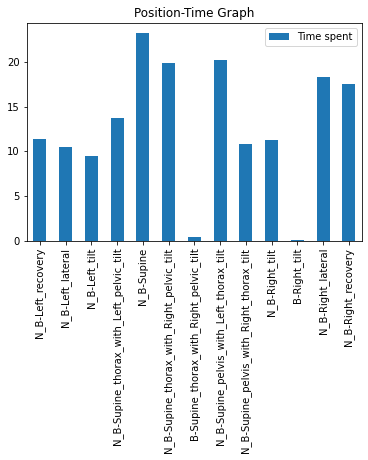

In [63]:
plt.figure(figsize=(10, 8))
n_df.plot(y = 'Time spent', kind='bar')
plt.title('Position-Time Graph')
plt.show()

#### Number of position changes

In [65]:
# Number of position changes
print('Number of position changes:', len(n_df.index))

Number of position changes: 13
